<h1><center>Physique numérique (PHY-3500)</center></h1>
<h1><center>TP1 - Intégration numérique</center></h1>

## Nom des membres de l'équipe:

### Légaré, Ophélie : 111 182 608
### Parrot, Anaïs : 111 184 980
### Turgeon, David : 111 182 265

### Importation des modules :

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.constants as cte
import scipy.stats as sta
from scipy.stats import moyal
from timeit import Timer,timeit
import scipy.integrate as sci
from scipy.integrate import quad

# Introduction : 

La radiothérapie externe est une méthode employée notamment dans le domaine de la radio-oncologie au CHUM pour le traitement du cancer. La radiothérapie externe traite les tumeurs au moyen de faisceaux de rayons X, d'électrons ou de hadrons. La protonthérapie, quant à elle, est une branche spécifique de la radiothérapie visant à traiter les tumeurs peu profondes, telles que les mélanomes oculaires, à l'aide de faisceaux de protons de faible énergie. Cette technique permet d'optimiser la ballistique du faisceau afin de cibler la tumeur tout en épargnant les tissus sains. [3]

Dans cette étude, on cherche à planifier et à prédire la dose reçue par un patient suivant un traitement de protonthérapie. Pour ce faire, la portée des protons dans la matière est déterminée à l'aide de méthodes d'intégration numérique, soit la méthode des trapèzes et la méthode de Simpson. Par la suite, les algorithmes sont comparés à une distribution de Moyal. Le calcul de l'énergie déposée par le faisceau de protons à la tumeur est réalisé à partir de son énergie cinétique. Finalement, le réalisme du modèle utilisé est discuté.

# Équations utiles :

Pouvoir d'arrêt collisionnel massique :

\begin{align}
\frac{S_{col}}{\rho} = -\left(\frac{dT}{\rho dx}\right) = NZ\int^{T_e^{max}}_0 T \left(\frac{d\sigma}{dT'}\right)_{col}dT'
\end{align}

L'énergie maximale transférable à un électron par le proton :

\begin{align}
T_e^{max} = \frac{2m_ec^2(\gamma^2-1)}{1+2\gamma\frac{m_e}{m_p}+\left(\frac{m_e}{m_p}\right)^2}
\end{align}

Pouvoir d'arrêt collisionnel pour les protons :

\begin{align}
-\left(\frac{dT}{dx}\right)_{col} = 2\pi r_e^2 m_e c^2 n_e \frac{Z^2}{\beta^2}\left [\ln\left(\frac{2m_e c^2(\gamma^2-1)T_e^{max}}{I^2} \right)-\delta+\\
2(-\beta^2-\frac{C}{Z}+ZL_1+Z^2L_2)\right]
\end{align}

Pouvoir d'arrêt collisionnel pour les protons de plus de 3 MeV (termes correctifs négligés) :

\begin{align}
S_{col}(T) = 2\pi r_e^2 m_e c^2 n_e \frac{1}{\beta^2} \left [\ln\left(\frac{2 m_e c^2 \beta^2 \gamma^2 T_e^{max}}{I^2}\right)-2\beta^2\right]
\end{align}

Portée des protons en ligne droite dans la matière :

\begin{align}
R_{CSDA} = \int^{T_i}_0 \frac{dT'}{\frac{S_{col}}{\rho}}
\end{align}

Énergie déposée pour un déplacement $s$ d'un proton dans un milieu :

\begin{align}
s = \int^{T_i}_{T_f} \frac{dT'}{S_{col}}
\end{align}

Les différentes variables utilisées sont :

- r_e le rayon classique de l'électron
- n_e la densité électronique du matériaux
- Z la charge de la particule (Z = 1 pour les protons)
- N le nombre d'atomes par gramme
- T' l'énergie transférée à l'électron de l'atome
- I l'énergie moyenne d'excitation du matériau
- $\frac{d\sigma}{dT}$ la section efficace différentielle pour les collisions inélastiques d'une énergie transféee T'
- $\beta$ et $\gamma$ les facteurs de Lorentz
- $\delta$ un terme considérant les effets de la polarisation
- $2\frac{C}{Z}$ corrige les effet du modèle en couches du cortège électronique atomique
- ZL$_1$ est la correction de Barkas
- Z$^2$L$_2$ est la correction de Bloch


## Question 1 :

La densité électronique d'un milieu peut être exprimée en fonction de sa composition atomique et de sa masse volumique à l'aide de l'équation suivante :

\begin{align}
n_e = \frac{N_A Z \rho}{A M_u} = 0.6022~x~10^{24}~ \frac{Z \rho}{A},
\end{align}

où $N_A$ est le nombre d'Avogadro, $Z$ est le numéro atomique, $\rho$ est la densité, $A$ est la masse atomique relative et $M_u$ est la  masse molaire. L'eau liquide et l'os compact (ICRU) sont des composés dont le numéro atomique et la masse atomique de chacun des éléments qui les composent sont pondérés selon leur fraction massique respective. Ces informations sont tirées de la source [1].

In [2]:
def densite_eau(rho,Z_1,A_1,Z_8,A_8):
    n_eau = (0.6022*10**(24))*rho*(0.111894*(Z_1/A_1)+0.888106*(Z_8/A_8))
    return n_eau

ne_eau = densite_eau(1.00000,1,1.00794,8,15.9994)
print(ne_eau, "électrons par cm^3")

3.342705085983941e+23 électrons par cm^3


In [3]:
def densite_os(rho,Z_1,A_1,Z_6,A_6,Z_7,A_7,Z_8,A_8,Z_12,A_12,Z_15,A_15,Z_16,A_16,Z_20,A_20):
    n_os = (0.6022*10**(24))*rho*(0.063984*(Z_1/A_1)+0.278000*(Z_6/A_6)+0.027000*(Z_7/A_7)+0.410016*(Z_8/A_8)+0.002000*(Z_12/A_12)+0.070000*(Z_15/A_15)+0.002000*(Z_16/A_16)+0.147000*(Z_20/A_20))
    return n_os

ne_os = densite_os(1.85000,1,1.00794,6,12.0107,7,14.0067,8,15.9994,12,24.3050,15,30.973762,16,32.065,20,40.078)
print(ne_os, "électrons par cm^3")

5.90576758009253e+23 électrons par cm^3


On veut maintenant calculer le pouvoir d'arrêt collisionnel grâce à l'équation 4 du TP. Pour ce faire, il faut commencer par calculer les facteurs de Lorentz $\beta$ et $\gamma$ et l'énergie maximale transferable à un électron par le proton $T_e^{max}$.

In [4]:
mp = cte.m_p # Masse du proton
me = cte.m_e  # Masse de l'électron
c = cte.c # Vitesse de la lumière dans le vide
r_e = cte.physical_constants["classical electron radius"][0]  # Rayon classique de l'électron

def Lorentz_factor(T): # T pour énergie cinétique du proton (en J)        
    gamma = T/(mp * c**2) + 1   # Équation 8 du TP
    beta = np.sqrt((gamma**2 - 1) / gamma**2)   # Équation 9 du TP
    return gamma, beta

def T_e_max(gamma):  # en J
    numerateur = 2*me*c**2*(gamma**2-1)
    denominateur = 1+2*gamma*me/mp + (me/mp)**2
    return numerateur/denominateur   # # Équation 2 du TP

def pouvoir_arret(T, n_e, I, power = 1, rho = 1):  # T et I en eV, "power" servira à mettre l'équation à la 
    # puissance -1 lors du calcul de la portée des protons dans la matière (voir la Question 5), rho servira à 
    # diviser le pouvoir d'arrêt par la masse volumique lorsqu'il est souhaité (comme à la Question 5).
    
    # Équation valide pour les protons de plus de 3 MeV !
    T *= cte.e # Transformation de l'énergie en eV vers des J
    I *= cte.e # Transformation de l'énergie d'excitation en eV vers des J
    gamma, beta = Lorentz_factor(T)
    Temax = T_e_max(gamma)
    
    arg_log = 2*me*c**2*beta**2*gamma**2*Temax/I**2
    S_col = 2*np.pi * (r_e*100)**2 * me*c**2 * n_e/beta**2 * (np.log(arg_log) - 2*beta**2)  # r_e mis en cm pour 
    # compenser n_e en cm^-3
    return (S_col/cte.e /rho)**power  # Pour avoir S_col en eV/cm

L'énergie moyenne d'excitation $I$ de l'eau liquide est de 75.000000 eV et celle de l'os compact (ICRU) est de 91.900000 eV selon [1]. Les courbes des pouvoirs d'arrêt collisionnel de l'eau liquide et de l'os compact sont présentées ci-dessous avec une échelle logarithmique en abscisse. 

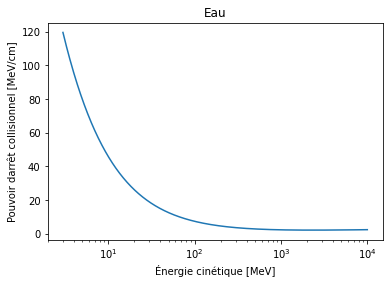

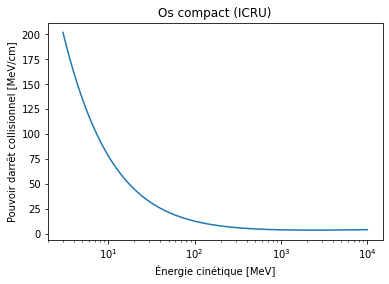

In [5]:
T = np.linspace(3, 10000, 100000)  # en MeV

plt.plot(T, pouvoir_arret(T*1e6, ne_eau, 75)/1e6)
plt.title("Eau")
plt.xlabel("Énergie cinétique [MeV]")
plt.ylabel('Pouvoir d''arrêt collisionnel [MeV/cm]')
plt.xscale('log')
plt.show()

plt.plot(T, pouvoir_arret(T*1e6, ne_os, 91.9)/1e6)
plt.title("Os compact (ICRU)")
plt.xlabel("Énergie cinétique [MeV]")
plt.ylabel('Pouvoir d''arrêt collisionnel [MeV/cm]')
plt.xscale('log')
plt.show()

En divisant le pouvoir d'arrêt collisionnel par la masse volumique, il est possible de comparer les courbes obtenues avec celles de la source [4]. On voit que les valeurs calculées tendent d'autant plus vers les valeurs théoriques de [1] qu'on s'éloigne de notre borne à 3 MeV. Cela est simplement dû à l'approximation utilisée ici de négliger les termes correctifs d'ordre supérieurs dans le calcul du pouvoir d'arrêt collisionnel.

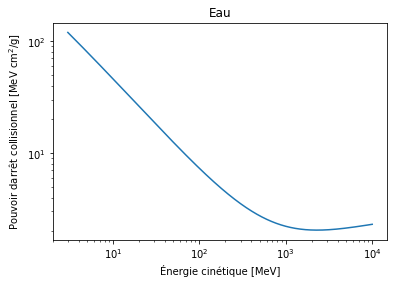

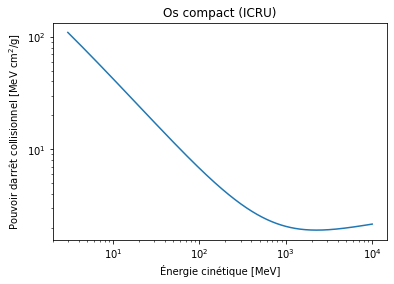

In [6]:
T = np.linspace(3, 10000, 100000)  # en MeV

plt.plot(T, pouvoir_arret(T*1e6, ne_eau, 75, 1, 1)/1e6)
plt.title("Eau")
plt.xlabel("Énergie cinétique [MeV]")
plt.ylabel('Pouvoir d''arrêt collisionnel [MeV cm$^2$/g]')
plt.xscale('log')
plt.yscale('log')
plt.show()

plt.plot(T, pouvoir_arret(T*1e6, ne_os, 91.9, 1, 1.85)/1e6)
plt.title("Os compact (ICRU)")
plt.xlabel("Énergie cinétique [MeV]")
plt.ylabel('Pouvoir d''arrêt collisionnel [MeV cm$^2$/g]')
plt.xscale('log')
plt.yscale('log')
plt.show()

# Portée des protons dans la matière

Pour calculer la portée des protons dans la matière, on utilise l'approximation d'une décération continue (CSDA) en ligne droite. La portée par CSDA est notée $R_{CSDA}$.

## Question 2 :
La portée des protons par CSDA est donnée par l'équation suivante [3]:
\begin{align}
R_{CSDA} = \int^{T_i}_0 \frac{dT'}{\frac{S_{col}}{\rho}},
\end{align}
soit l'intégrale de l'inverse du pouvoir d'arrêt collisionnel massique par rapport à l'énergie transférée à l'électron de l'atome.
L'homogénéité dimensionnelle de la portée des protons en ligne droite est déterminée en vérifiant les unités de part et d'autre de l'égalité. Selon l'outil PSTAR du NIST, les unités sont des g/$cm^2$ [1]. On développe le côté droit de l'égalité afin de vérifier l'homogénéité dimensionnelle pour des protons de plus de 3 MeV.

\begin{align}
R_{CSDA} = \int^{T_i}_0 \frac{dT'}{\frac{S_{col}}{\rho}} = \int^{T_i}_0 \frac{\rho \ dT'}{2\pi r_e^2 m_e c^2 n_e \frac{1}{\beta^2} \left [\ln\left(\frac{2 m_e c^2 \beta^2 \gamma^2 T_e^{max}}{I^2}\right)-2\beta^2\right]} = \int^{T_i}_0 \frac{\rho \ dT'}{-\left(\frac{dT}{dx}\right)_{col}}.
\end{align}
Les unités sont donc :
\begin{align}
\left[\frac{g}{cm^2}\right] = \int^{T_i}_0 dT'\frac{\left[\frac{g}{cm^3}\right]}{\left[\frac{MeV}{cm}\right]} = \int^{T_i}_0 dT'\left[\frac{g}{MeV cm^2}\right].
\end{align}

En intégrant cette fonction par rapport à l'énergie, on obtient les mêmes unités de part et d'autre de l'égalité :

\begin{align}
\left[\frac{g}{cm^2}\right] = \left[\frac{g}{cm^2}\right],
\end{align}

donc l'homogénéité dimensionnelle de la portée des protons en ligne droite est démontrée.

## Question 3 :
Le pouvoir d'arrêt collisionnel total pour une particule donnée est composé de l'arrêt collisionnel électronique (ionisation des atomes) et de l'arrêt collisionnel nucléaire (diffusion sur des noyaux). Il est également possible que cette particule donnée subisse des pertes radiatives (Bremsstrahlung, production de paires ou intéraction photoélectrique) durant sa trajectoire dans la matière. [6]

Pour les protons dans la gamme des énergies de la protonthérapie, le pouvoir d'arrêt collisionnel total peut être approximé par le pouvoir d'arrêt collisionnel électronique puisque tous deux sont du même ordre de grandeur peu importe l'énergie du proton. En effet, si on base notre analyse sur les résultats de l'outil PSTAR du NIST [1] pour l'eau liquide, on remarque que ces deux derniers présentent un écart d'au plus 0,08%. Pour ce qui est de l'arrêt collisionnel nucléaire, celui-ci est inférieur par un facteur d'environ $10^{3}$ pour les énergies de la protonthérapie. Cet écart s'accroît rapidement jusqu'à $10^{5}$ pour des énergies supérieures. Le pouvoir d'arrêt collisionnel nucléaire peut donc être négligé. On note que des résultats du même ordre de grandeur sont obtenus pour l'os compact (ICRU) à l'aide de cet outil, ce qui confirme que cette approximation est valide aussi dans ce milieu.

Quant aux pertes radiatives, elles sont davantage présentes dans le comportement des particules légères telles que les électrons et les positrons qui subissent des pertes non négligeables même pour des faibles énergies de l'ordre de $10^{-2}$ MeV. Dans le cas des protons, les pertes radiatives sont présentes pour des énergies de l'ordre de $10^{3}$ MeV et prennent plus d'importance pour des énergies encore plus élevées qui ne font pas partie de la gamme des énergies utilisées en protonthérapie. C'est la masse élevée des protons qui réduit l'effet des pertes radiatives en protonthérapie. [6]

## Question 4 :
Il est nécessaire d'employer une méthode numérique pour calculer la portée des protons, car il n'est pas possible de calculer cette dernière de façon analytique. [3] Tel que présenté à la question 1, le pouvoir d'arrêt collisionnel varie en fonction de l'énergie des protons et du milieu traversé par le faisceau de protons. La portée des protons dépend, entre autres, des énergies de faisceau sélectionnées, de la forme et de la profondeur de la tumeur à traiter, de l'anatomie ainsi que de la morphologie spécifique du patient. Il s'agit de calculs complexes et laborieux qui nécessitent une exactitude au millimètre ou même au dixième de millimètre près afin de préserver les tissus sains. La calul numérique de la portée des protons permet d'économiser du temps lors de la préparation du traitement de chaque patient et de s'assurer que la ballistique du traitement est exacte et optimale.

## Question 5 :

Comme mentionné en introduction, deux méthodes d'intrégration seront utilisés ici : la méthode des trapèzes et la méthode de Simpson. Leur algorithme respectif est écrit ci-dessous et s'inspire des équations présentées par [2].

In [7]:
def methode_trapezes(fonction, a, b, N, *args):  
    # fonction = celle à intégrer, a = 1ère borne d'intégration, b = 2e borne d'intégration, N = nombre de tranches,
    # *args permet de rentrer des arguments supplémentaires propre à la fonction à intégrer
    if N == 0:   # Pour éviter une division par zéro (au calcul de h)
        return 0

    x = np.linspace(a, b, N+1) 
    h = (b - a) / N  # Épaisseur de chaque tranche
    somme = 0
    for i in x[1:-1]:
        somme += fonction(i, *args)
    
    return h * (1/2*fonction(x[0], *args) + 1/2*fonction(x[-1], *args) + somme)

def methode_Simpson(fonction, a, b, N, *args):
    # fonction = celle à intégrer, a = 1ère borne d'intégration, b = 2e borne d'intégration, N = nombre de tranches,
    # *args permet de rentrer des arguments supplémentaires propre à la fonction à intégrer
    if N == 0:   # Pour éviter une division par zéro (au calcul de h)
        return 0
    
    x = np.linspace(a, b, N+1)
    h = (b - a) / N  # Épaisseur de chaque tranche
    somme_impaire = 0
    somme_paire = 0
    for i in x[1:-1:2]:
        somme_impaire += fonction(i, *args)
    for i in x[2:-2:2]:
        somme_paire += fonction(i, *args)
    
    return 1 / 3 * h * (fonction(x[0], *args) + fonction(x[-1], *args) + 4 * somme_impaire + 2 * somme_paire)

Avant de calculer la portée des protons dans la matière avec ces deux méthodes d'intégration, il faut commencer par déterminer le nombre maximal de tranches à utiliser pour atteindre une précision comparable à celle de la machine en Python. Bien entendu, comme la méthode d'intégration change pour celle des trapèzes et celle de Simpson, il faut calculer un nombre maximal de tranches pour chaque technique. Les équations utilisées pour y parvenir sont tirées de [2] et l'intégrale est effectuée de 3 MeV à 150 MeV.

In [8]:
def calcul_erreur(precision, methode, fonction, a, b, N, *args):
    # precision permet d'imposer la précision souhaitée pour le résultat de notre intégration. Cela nous sera utile
    # pour la question 9. methode permet de choisir quelle méthode d'intégration (trapèzes ou Simpson) est utilisée
    # pour déterminer le nombre de tranches maximal. N est le nombre de tranches initial à tester.
    
    N_tranches = []
    portee_protons = []
    err = []
    I_prec = 0
    erreur = 1
    erreur_prec = 1
    
    if str(methode.__name__) == "methode_trapezes":   # Pour la méthode des trapèzes
        while abs(erreur) > I_prec*precision:   # Itérer jusqu'à atteindre la précision voulue
            
            if I_prec == 0:   # Paramètres initiaux
                I_prec = methode(fonction, a, b, N, *args)
                N_i = N * 2
                
            else:  # Paramètres suivants
                erreur_prec = erreur
                h_i = (b - a) / N_i
                somme = 0
                for k in range(1, N_i, 2):
                    somme += fonction(a+k*h_i, *args)

                I_i = 1/2 * I_prec + h_i * somme
                erreur = 1/3 * (I_i - I_prec)
                
                if abs(erreur_prec) < abs(erreur):  # Si l'erreur cesse de diminuer, on arrête l'itération puisque
                    break   # nous avons atteint l'erreur d'approximation de la méthode. 
                
                N_tranches.append(N_i)
                portee_protons.append(I_i)
                err.append(abs(erreur))
                
                I_prec = I_i
                N_i *= 2
        
        return N_tranches, portee_protons, err
    
    elif str(methode.__name__) == "methode_Simpson":   # Pour la méthode de Simpson
        while abs(erreur) > I_prec*precision:  # Itérer jusqu'à atteindre la précision voulue
            
            if I_prec == 0:   # Paramètres initiaux
                h_i = (b - a) / N  
                somme_impaire = 0
                somme_paire = 0
                for k in range(2, N, 2):
                    somme_paire += fonction(a+k*h_i, *args)
                S_i_prec = 1/3 * (fonction(a, *args) + fonction(b, *args) + 2*somme_paire)
                
                for k in range(1, N, 2):
                    somme_impaire += fonction(a+k*h_i, *args)
                T_i_prec = 2/3*somme_impaire
                
                I_prec = h_i * (S_i_prec + 2*T_i_prec)
                N_i = N * 2
                
            else:   # Paramètres suivants
                erreur_prec = erreur
                h_i = (b - a) / N_i 
                S_i = S_i_prec + T_i_prec
                
                somme_impaire = 0
                for k in range(1, N_i, 2):
                    somme_impaire += fonction(a+k*h_i, *args)
                T_i = 2/3*somme_impaire
                I_i = h_i * (S_i + 2 * T_i) 
                
                erreur = 1/15 * (I_i - I_prec)
                
                if abs(erreur_prec) < abs(erreur):  # Si l'erreur cesse de diminuer, on arrête l'itération puisque
                    break   # nous avons atteint l'erreur d'approximation de la méthode. 
                
                N_tranches.append(N_i)
                portee_protons.append(I_i)
                err.append(abs(erreur))
                
                I_prec = I_i
                S_i_prec = S_i
                T_i_prec = T_i
                N_i *= 2
                
        return N_tranches, portee_protons, err
    
    else:
        raise ValueError("La méthode doit être 'methode_trapeze' ou bien 'methode_Simpson'.")

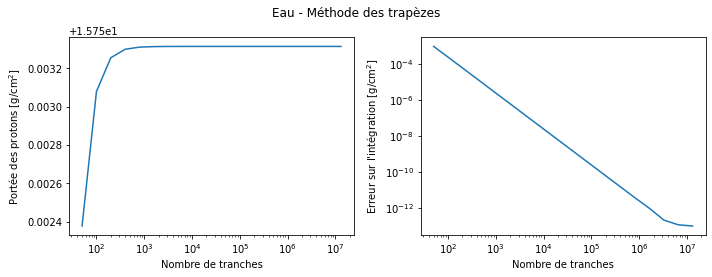

In [9]:
erreur_eau_trapezes = calcul_erreur(1e-16, methode_trapezes, pouvoir_arret, 3e6, 150e6, 25, ne_eau, 75, -1, 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
fig.suptitle("Eau - Méthode des trapèzes")
ax1.plot(erreur_eau_trapezes[0], erreur_eau_trapezes[1])
ax1.set(xlabel="Nombre de tranches", ylabel="Portée des protons [g/cm$^2$]")
ax1.semilogx()
ax2.plot(erreur_eau_trapezes[0], erreur_eau_trapezes[2])
ax2.set(xlabel="Nombre de tranches", ylabel="Erreur sur l'intégration [g/cm$^2$]")
ax2.loglog()
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

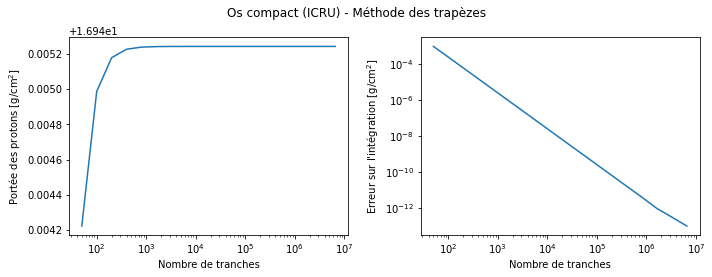

In [10]:
erreur_os_trapezes = calcul_erreur(1e-16, methode_trapezes, pouvoir_arret, 3e6, 150e6, 25, ne_os, 91.9, -1, 1.85)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
fig.suptitle("Os compact (ICRU) - Méthode des trapèzes")
ax1.plot(erreur_os_trapezes[0], erreur_os_trapezes[1])
ax1.set(xlabel="Nombre de tranches", ylabel="Portée des protons [g/cm$^2$]")
ax1.semilogx()
ax2.plot(erreur_os_trapezes[0], erreur_os_trapezes[2])
ax2.set(xlabel="Nombre de tranches", ylabel="Erreur sur l'intégration [g/cm$^2$]")
ax2.loglog()
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [19]:
print("Le nombre maximal de tranches pour atteindre l'erreur d'approximation de la méthode des trapèzes est supérieur à", erreur_eau_trapezes[0][-1], "pour l'eau et est supérieur à", erreur_os_trapezes[0][-1], "pour l'os compact.")
print("On peut ainsi poser le nombre maximal de tranches à 4e6 pour la méthode des trapèzes.")

Le nombre maximal de tranches pour atteindre l'erreur d'approximation de la méthode des trapèzes est supérieur à 13107200 pour l'eau et est supérieur à 6553600 pour l'os compact.
On peut ainsi poser le nombre maximal de tranches à 4e6 pour la méthode des trapèzes.


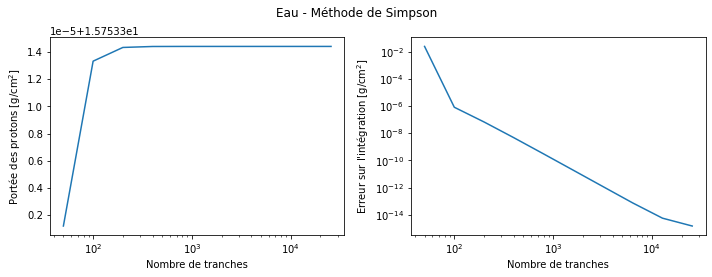

In [20]:
erreur_eau_Simpson = calcul_erreur(1e-16, methode_Simpson, pouvoir_arret, 3e6, 150e6, 25, ne_eau, 75, -1, 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
fig.suptitle("Eau - Méthode de Simpson")
ax1.plot(erreur_eau_Simpson[0], erreur_eau_Simpson[1])
ax1.set(xlabel="Nombre de tranches", ylabel="Portée des protons [g/cm$^2$]")
ax1.semilogx()
ax2.plot(erreur_eau_Simpson[0], erreur_eau_Simpson[2])
ax2.set(xlabel="Nombre de tranches", ylabel="Erreur sur l'intégration [g/cm$^2$]")
ax2.loglog()
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

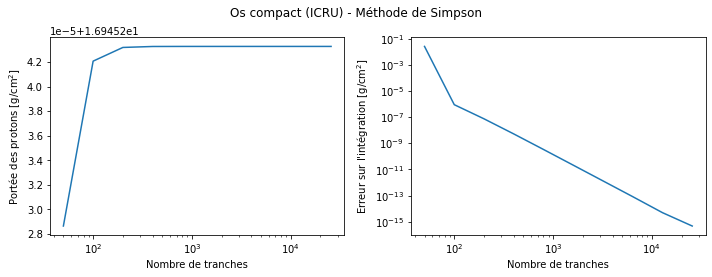

In [21]:
erreur_os_Simpson = calcul_erreur(1e-16, methode_Simpson, pouvoir_arret, 3e6, 150e6, 25, ne_os, 91.9, -1, 1.85)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
fig.suptitle("Os compact (ICRU) - Méthode de Simpson")
ax1.plot(erreur_os_Simpson[0], erreur_os_Simpson[1])
ax1.set(xlabel="Nombre de tranches", ylabel="Portée des protons [g/cm$^2$]")
ax1.semilogx()
ax2.plot(erreur_os_Simpson[0], erreur_os_Simpson[2])
ax2.set(xlabel="Nombre de tranches", ylabel="Erreur sur l'intégration [g/cm$^2$]")
ax2.loglog()
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [22]:
print("Le nombre maximal de tranches pour atteindre l'erreur d'approximation de la méthode de Simpson est supérieur à", erreur_eau_Simpson[0][-1], "pour l'eau et est supérieur à", erreur_os_Simpson[0][-1], "pour l'os compact.")
print("On peut ainsi poser le nombre maximal de tranches à 3e4 pour la méthode des trapèzes.")

Le nombre maximal de tranches pour atteindre l'erreur d'approximation de la méthode de Simpson est supérieur à 25600 pour l'eau et est supérieur à 25600 pour l'os compact.
On peut ainsi poser le nombre maximal de tranches à 3e4 pour la méthode des trapèzes.


## Question 6 :

On obtient l'expression analytique de la dérivée du pouvoir d'arrêt collisionnel en fonction de T en l'exprimant en fonction de $\gamma$ et en utilisant le théorème de dérivation des fonctions composées. Le pouvoir d'arrêt collisionnel en fonction de T pour des protons de plus de 3 MeV est donné par

\begin{align}
S_{col}(T) = 2\pi r_e^2 m_e c^2 n_e \frac{1}{\beta^2} \left [\ln\left(\frac{2 m_e c^2 \beta^2 \gamma^2 T_e^{max}}{I^2}\right)-2\beta^2\right].
\end{align}

Avec les simplifications et les substitutions suggérées dans l'énoncé, on obtient les équations suivantes.

\begin{align}
S_{col}(T) = U \frac{1}{\beta^2} \left [\ln\left(\frac{a (\gamma^2-1)}{I^2} \frac {a (\gamma^2-1)}{\gamma \delta + b}\right)-2\beta^2\right]
\end{align}

\begin{align}
S_{col}(T) = U \frac{1}{\beta^2} \left [\ln\left(\frac{k (\gamma^2-1)^2}{\gamma \delta + b}\right)-2\beta^2\right]
\end{align}

\begin{align}
S_{col}(T) = \frac{U \gamma^2}{(\gamma^2-1)} \left [\ln\left(\frac{k (\gamma^2-1)^2}{\gamma \delta + b}\right)-2\frac{(\gamma^2-1)}{\gamma^2}\right]
\end{align}

\begin{align}
S_{col}(T) = \frac{U \gamma^2}{(\gamma^2-1)} \ln\left(\frac{k (\gamma^2-1)^2}{\gamma \delta + b}\right)-2U
\end{align}

Sachant que $\gamma$ peut s'exprimer en fonction de $T$ comme suit

\begin{align}
\gamma = \frac{T}{m_pc^2}+1,
\end{align}

on peut se servir du théorème de dérivation des fonctions composées pour obtenir la dérivée du pouvoir d'arrêt collisionnel en fonction de T de la manière suivante :

\begin{align}
\frac{dS_{col}}{dT} = \frac{dS_{col}}{d\gamma}\frac{d\gamma}{dT} 
\end{align}

La première dérivée est 

\begin{align}
\frac{dS_{col}}{d\gamma} = U \frac{d}{d\gamma} \left[\frac{\gamma^2}{(\gamma^2-1)} ln\left(\frac{k (\gamma^2-1)^2}{\gamma \delta + b}\right) \right]
\end{align}

\begin{align}
\frac{dS_{col}}{d\gamma} = U \Bigg(\left[\frac{\gamma(\gamma^2-1)-\gamma^2(2\gamma)}{(\gamma^2-1)^2} ln\left(\frac{k (\gamma^2-1)^2}{\gamma \delta + b}\right) \right] + \left[\frac{\gamma^2}{(\gamma^2-1)}\frac{\gamma \delta + b}{k (\gamma^2-1)^2}\frac{4k\gamma\left(\gamma^2-1\right)\left(\gamma \delta + b \right) - k\delta\left(\gamma^2-1\right)^2}{(\gamma \delta + b)^2} \right]\Bigg)
\end{align}

\begin{align}
\frac{dS_{col}}{d\gamma} = U \Bigg(\left[\frac{\gamma(\gamma^2-1)-2\gamma^3}{(\gamma^2-1)^2} ln\left(\frac{k (\gamma^2-1)^2}{\gamma \delta + b}\right) \right] + \left[\frac{\gamma^2(\gamma \delta + b)}{k(\gamma^2-1)^3}\frac{4k\gamma(\gamma^2-1)(\gamma \delta + b) - k\delta(\gamma^2-1)^2}{(\gamma \delta + b)^2} \right]\Bigg).
\end{align}

La deuxième dérivée est simplement 

\begin{align}
\frac{d\gamma}{dT} = \frac{1}{m_pc^2}.
\end{align}

Ainsi, selon le théorème de dérivation des fonctions composées, on obtient

\begin{align}
\frac{dS_{col}}{dT} = \frac{U}{m_pc^2} \Bigg(\left[\frac{\gamma(\gamma^2-1)-2\gamma^3}{(\gamma^2-1)^2} ln\left(\frac{k (\gamma^2-1)^2}{\gamma \delta + b}\right) \right] + \left[\frac{\gamma^2(\gamma \delta + b)}{k(\gamma^2-1)^3}\frac{4k\gamma(\gamma^2-1)(\gamma \delta + b) - k\delta(\gamma^2-1)^2}{(\gamma \delta + b)^2} \right]\Bigg).
\end{align}


Maintenant, on l'implémente en Python pour pouvoir la tracer. La courbe de la dérivée du pouvoir d'arrêt collisionnel est tracée pour des protons dans l'eau puis dans l'os.

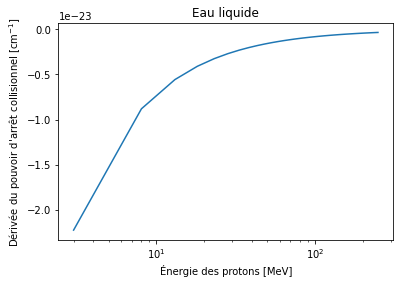

In [38]:
U_eau = 2 * np.pi * r_e**2 * me * c**2 * ne_eau
a = 2*me*c**2
b = 1+(me/mp)**2
k_eau = (a/(75))**2  # I = 75.000 eV pour l'eau
delta = 2*me/mp

T = np.linspace(3*1e6, 250*1e6)  # en eV
data = []
for i in T:
    gamma = i/(mp * c**2) + 1
    dS_col = U_eau/(mp*c**2)*((((gamma*(gamma**2 -1)-2*gamma**3)/(gamma**2-1)**2)*np.log(k_eau*(gamma**2-1)**2/(gamma*delta+b)))+((gamma**2*(gamma*delta+b)*(4*k_eau*gamma*(gamma**2-1)*(gamma*delta+b)-k_eau*delta*(gamma**2-1)**2))/(k_eau*(gamma**2-1)**3*(gamma*delta+b)**2)))
    data.append(dS_col)

plt.plot(T/1e6, data)
plt.xscale("log")
plt.xlabel("Énergie des protons [MeV]")
plt.ylabel("Dérivée du pouvoir d'arrêt collisionnel [cm$^{-1}$]")
plt.title("Eau liquide")
plt.show()

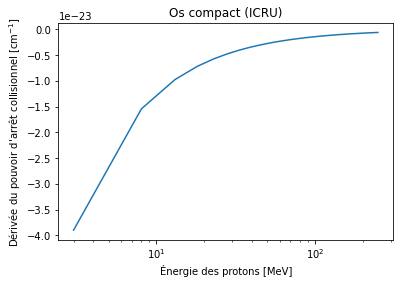

In [40]:
U_os = 2 * np.pi * r_e**2 * me * c**2 * ne_os
a = 2*me*c**2
b = 1+(me/mp)**2
k_os = (a/(91.9))**2  # I = 91.900 eV pour l'os
delta = 2*me/mp

T = np.linspace(3*1e6, 250*1e6)  # en eV
data = []
for i in T:
    gamma = i/(mp * c**2) + 1
    dS_col = U_os/(mp*c**2)*((((gamma*(gamma**2 -1)-2*gamma**3)/(gamma**2-1)**2)*np.log(k_os*(gamma**2-1)**2/(gamma*delta+b)))+((gamma**2*(gamma*delta+b)*(4*k_os*gamma*(gamma**2-1)*(gamma*delta+b)-k_os*delta*(gamma**2-1)**2))/(k_os*(gamma**2-1)**3*(gamma*delta+b)**2)))
    data.append(dS_col)

plt.plot(T/1e6, data)
plt.xscale("log")
plt.xlabel("Énergie des protons [MeV]")
plt.ylabel("Dérivée du pouvoir d'arrêt collisionnel [cm$^{-1}$]")
plt.title("Os compact (ICRU)")
plt.show()

## Question 7 :

In [28]:
def erreur_approx_trapeze(fonction, a, b,N,n, *args): # n est la distance des points utilisé pour faire la dérivée
    
    h = (b - a) / N

    v_a0 = fonction(a,*args)
    v_a1 = fonction(a+n,*args)
    v_a2 = fonction(a-n,*args)
    
    p_a1 = (v_a0-v_a1)/(n)
    p_a2 = (v_a0-v_a2)/(-n)
    da = (p_a1+p_a2)/2 # dérivée autour de a
    
    v_b0 = fonction(b,*args)
    v_b1 = fonction(b+n,*args)
    v_b2 = fonction(b-n,*args)
    
    p_b1 = (v_b0-v_b1)/(n)
    p_b2 = (v_b0-v_b2)/(-n)
    db = (p_b1+p_b2)/2 # dérivée autour de b
    print(p_a1,p_a2)
    return 1/12*h**2*(da-db)
print(erreur_approx_trapeze(pouvoir_arret, 3e6, 150e6, 3200,1e-6, ne_eau, 75,-1))
print(pouvoir_arret(3e6,ne_eau,75,-1))

-1.788364484339646e-15 -2.2350420151182808e-15
-1.978302601322867e-07
8.367659755516127e-09


# Optimisation

On va maintenant évaluer la vitesse d'exécution des deux méthodes d'intégration utilisées, ainsi que la méthode déjà implémentée en Python <code>scipy.integrate.quad</code>.

## Question 8 :
La distribution en énergie des protons peut être approximée par une distribution de Moyal. Ici 10 000 énergies sont générées à partir de cette distribution centrée à 150 MeV telle que présentée par la figure suivante.

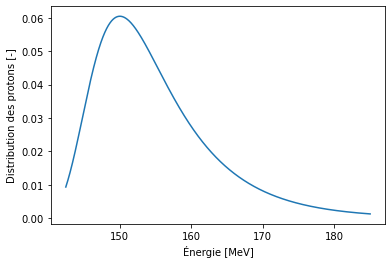

In [29]:
r_energie = moyal.rvs(size=10000, loc = 150, scale = 4)
ppf_energie = np.linspace(moyal.ppf(0.01, loc=150, scale=4), moyal.ppf(0.99, loc=150, scale=4), 10000)
distribution = moyal.pdf(ppf_energie, loc=150, scale=4)
 
plt.plot(ppf_energie, distribution) 
plt.xlabel("Énergie [MeV]")
plt.ylabel("Distribution des protons [-]")
plt.show()

## Question 9 :
Afin d'optimiser et de comparer les méthodes d'intégrations développées précédemment, on veut évaluer le nombre de protons calculés par seconde pour chacune d'elle; soit la méthode des trapèzes et la méthode de Simpson. On cherche à minimiser le temps de calcul dans l'optique de connaître la portée de chaque proton en temps quasi-réel. La fonction <code>scipy.integrate.quad</code> est également utilisée pour estimer le nombre de protons calculés par seconde à partir des 10 000 énergies générées par la distribution de Moyal.

In [30]:
# À COUPER?? DAVID, À TOI DE CHOISIR ;) 

"""
def trouver_N_trapeze_pour_precision(a,b,n,precision,fonction,*args):
    error = 1
    N = 1
    trapz = methode_trapezes(fonction,a, b, 100000, *args)
    h = (b - a) / N

    v_a0 = fonction(a,*args)
    v_a1 = fonction(a+n,*args)
    v_a2 = fonction(a-n,*args)

    p_a1 = (v_a0-v_a1)/(n)
    p_a2 = (v_a0-v_a2)/(-n)
    da = (p_a1+p_a2)/2 # dérivée autour de a

    v_b0 = fonction(b,*args)
    v_b1 = fonction(b+n,*args)
    v_b2 = fonction(b-n,*args)

    p_b1 = (v_b0-v_b1)/(n)
    p_b2 = (v_b0-v_b2)/(-n)
    db = (p_b1+p_b2)/2 # dérivée autour de b

    N = (b-a)*np.sqrt(abs(da-db)/(12*trapz*precision))
    return N

print(trouver_N_trapeze_pour_precision(3e6,150e6,1e-6,1.49e-8,pouvoir_arret, ne_eau, 75,-1,1))
"""

'\ndef trouver_N_trapeze_pour_precision(a,b,n,precision,fonction,*args):\n    error = 1\n    N = 1\n    trapz = methode_trapezes(fonction,a, b, 100000, *args)\n    h = (b - a) / N\n\n    v_a0 = fonction(a,*args)\n    v_a1 = fonction(a+n,*args)\n    v_a2 = fonction(a-n,*args)\n\n    p_a1 = (v_a0-v_a1)/(n)\n    p_a2 = (v_a0-v_a2)/(-n)\n    da = (p_a1+p_a2)/2 # dérivée autour de a\n\n    v_b0 = fonction(b,*args)\n    v_b1 = fonction(b+n,*args)\n    v_b2 = fonction(b-n,*args)\n\n    p_b1 = (v_b0-v_b1)/(n)\n    p_b2 = (v_b0-v_b2)/(-n)\n    db = (p_b1+p_b2)/2 # dérivée autour de b\n\n    N = (b-a)*np.sqrt(abs(da-db)/(12*trapz*precision))\n    return N\n\nprint(trouver_N_trapeze_pour_precision(3e6,150e6,1e-6,1.49e-8,pouvoir_arret, ne_eau, 75,-1,1))\n'

In [31]:
### Avoir le nombre de tranche pour trapèze et Simpson
#N_trapeze_eau = calcul_erreur(1.49e-8 ,methode_trapezes, pouvoir_arret, 3e6, 150e6, 100, ne_eau, 75, -1, 1)[1][-1]
#N_Simpson_eau = calcul_erreur(1.49e-8 ,methode_Simpson, pouvoir_arret, 3e6, 150e6, 100, ne_eau, 75, -1, 1)[1][-1]

pouvoir_arret_eau_quad = lambda x : pouvoir_arret(x,ne_eau,75,-1,1)
somme_quad = 0
somme_trapeze = 0
a = 0
N_trapeze_eau = calcul_erreur(1.49e-8 ,methode_trapezes, pouvoir_arret, 3e6, i*1e6, 100, ne_eau, 75, -1, 1)[0][-1]
portee_eau = np.zeros(10000)
for i in r_energie:
    somme_trapeze += timeit("methode_trapezes(pouvoir_arret, 3e6, i*1e6, N_trapeze_eau, ne_eau, 75, -1, 1)",globals=globals(),number = 1)
    somme_quad += timeit("quad(pouvoir_arret_eau_quad,3e6,i*1e6)",globals=globals(),number = 1)
    portee_eau[a] = quad(pouvoir_arret_eau_quad,3e6,i*1e6)[0]
    if a%250 == 0:
        print(somme_trapeze,somme_quad, a)
    a += 1


IndexError: list index out of range

In [32]:
print(f"Il est possible de mesurer {(somme_quad/10000)**-1} protons par seconde, à l'aide de la fonction quad de scipy.integrate.")
print(f"Il est possible de mesurer {(somme_trapeze/10000)**-1} protons par seconde, à l'aide de la méthode des trapèzes.")

ZeroDivisionError: 0.0 cannot be raised to a negative power

## Question 10
La portée des 10 000 protons dont l'énergie a été générée par la distribution de Moyal est présentée ci-dessous sous la forme d'un histogramme. On note que la courbe de l'histogramme est centrée autour d'une portée de 16 cm, puis que la largeur à la mi-hauteur (FWHM) de la courbe obtenue est d'environ 2.5 cm donc la majorité de ces protons dont l'énergie se concentre autour de 150 MeV ont une portée entre 15.0 cm et 17.5 cm dans l'eau. Quelques protons ont une portée allant jusqu'à 28 cm mais en quantité négligeable. En effet, la portion de l'histogramme à droite du pic central décroît en amplitude de façon exponentielle pour atteindre des proportions de moins de 0.01% pour des portées de 22 cm et plus.

In [33]:
plt.hist(portee_eau,bins = 200, density = True)
plt.xlabel("Portée des protons (cm)")
plt.show()

NameError: name 'portee_eau' is not defined

# Énergie déposée

Dans cette section, on va évaluer l'énergie déposée pas à pas par un proton lors de son passage dans un milieu.

## Question 11
Le point où l'énergie déposée est nulle représente la distance à laquelle les protons s'arrêtent. Il est situé juste après le pic de Bragg. À cette portée dans le milieu donné, les protons ont transmis la totalité de leur énergie cinétique aux atomes se trouvant sur leur trajectoire. La position de ce point d'arrêt dépend de la nature des particules du faisceau, de l'énergie de celles-ci et de la nature du milieu traversé. 

Par exemple, un faisceau d'électrons a une plus grande portée qu'un faisceau de protons. Des particules hautement énergétiques ont une portée plus élevée dans la matière. Finalement, un milieu traversé ayant une masse volumique élevée freine davantage le faisceau de particules tel que démontré ici en comparant la portée des protons dans l'eau liquide et celle dans l'os compact.

<ipython-input-43-ff03f9666df1>:19: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  resul += abs(quad(pouvoir_arret_eau_quad, i_prec, i)[0])


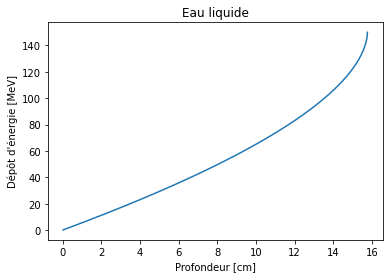

In [43]:
"""
Le prof a répondu sur le forum : La dose est définie comme l'énergie déposée par unité de masse [par ex. J/kg].
Donc, est-ce qu'il faut diviser par la masse volumique même si c'est pas écrit dans la formule?

Je pense que ce n'est pas nécessaire, car il demande de tracer le dépôt d'énergie. Tandis que s'il demandait la dose, là on
diviserait par la masse volumique:) mais je peux le préciser dans le texte pour lui montrer qu'on a compris ça.
"""


pouvoir_arret_eau_quad = lambda x : pouvoir_arret(x, ne_eau, 75, -1) 

s = []
depot = []
resul = 0
num_intervalle = 1
for i in np.linspace(150e6, 0, 1000):
    if i == 150e6:
        i_prec = i
    else:
        resul += abs(quad(pouvoir_arret_eau_quad, i_prec, i)[0]) 
        s.append(resul)
        depot.append((i_prec - i)*num_intervalle/1e6)  # Pour avoir en MeV
        i_prec = i
        num_intervalle += 1

plt.figure()
plt.plot(s, depot)
plt.xlabel("Profondeur [cm]")
plt.ylabel("Dépôt d'énergie [MeV]")
plt.title("Eau liquide")
plt.show()

<ipython-input-35-dacde29bb4f4>:11: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  resul += abs(quad(pouvoir_arret_os_quad, i_prec, i)[0])


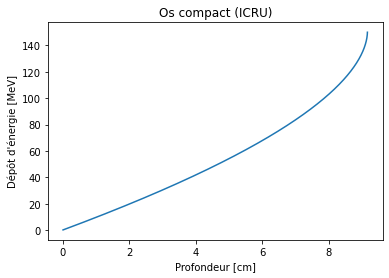

In [35]:
pouvoir_arret_os_quad = lambda x : pouvoir_arret(x, ne_os, 91.9, -1) 

s = []
depot = []
resul = 0
num_intervalle = 1
for i in np.linspace(150e6, 0, 1000):
    if i == 150e6:
        i_prec = i
    else:
        resul += abs(quad(pouvoir_arret_os_quad, i_prec, i)[0]) 
        s.append(resul)
        depot.append((i_prec - i)*num_intervalle/1e6)  # Pour avoir en MeV
        i_prec = i
        num_intervalle += 1

plt.figure()
plt.plot(s, depot)
plt.xlabel("Profondeur [cm]")
plt.ylabel("Dépôt d'énergie [MeV]")
plt.title("Os compact (ICRU)")
plt.show()

On remarque qu'il y a bel et bien une décélération des protons dans la matière, puisqu'il a davantage d'énergie déposée dans les derniers centimètres parcourus. On voit également que la profondeur parcourue par le proton avant d'être complètement freinée est d'autant plus courte que la masse volumique du matériau est élevée. 

Dans ces figures, c'est le dépôt énergétique qui est présenté en MeV. La dose est l'énergie déposée par unité de masse et elle s'exprime en J/kg, elle pourrait être obtenue simplement en divisant l'énergie par la masse volumique de la matière et en la multipliant par le volume de matière exposé au faisceau.

# Votre courbe comportera un point où l’énergie déposée est nulle. La position de ce point est-elle conforme à vos résultats antérieurs sur la portée ? 

Le point où l'énergie déposée est nulle devrait se situer juste après le point où l'énergie déposée est maximale, soit après le pic de Bragg. Dans le cas de l'eau liquide, le pic de Bragg se situe autour de 15.77 cm puis pour l'os compact il se trouve autour de 9.0 cm. Ces résultats confirment que la portée des protons est supérieure dans un milieu de faible densité.

## Question 12

La courbe de Bragg représente le dépôt d'énergie du faisceau de rayonnement ionisant en fonction de la profondeur dans le milieu traversé par ceux-ci. Le pic de Bragg indique la portée où la quantité d'énergie déposée est maximale et se situe juste avant que l'énergie déposée soit nulle. Ce pic est causé par l'augmentation de la section efficace d'interaction entre les protons et les molécules du milieu.

Dans la question précédente, il s'agissait d'un faisceau monoénergétique de protons à 150 MeV se propageant dans l'eau et dans l'os compact. En se basant sur les courbes de Bragg obtenues pour ces deux milieux, les protons sont idéals pour la radiothérapie puisque leur pic de Bragg est très étroit et décroît rapidement pour des distances supérieures. Il est donc possible de traiter avec précision des tumeurs de petites tailles sans affecter les tissus environnants. De plus, la possibilité d'utiliser des faisceaux de protons de faibles énergies permet de minimiser leur portée pour des tumeurs peu profondes telles que les mélanomes oculaires. 

Il serait également possible de modifier le faisceau de protons de 150 MeV afin d'élargir la zone où l'énergie déposée est maximale afin de traiter des tumeurs de plus grandes tailles ou de forme complexe. Dans ce cas, le pic de Bragg serait converti en un plateau de moins haute énergie et la position pour laquelle l'énergie déposée est nulle resterait la même.

## Question 13

On cherche l'énergie nécessaire pour que le faisceau de protons puissent traiter un mélanome oculaire situé à 4 cm de la surface oculaire. On considère que le seul milieu traversé est de l'eau.

In [36]:
def portee_selon_energie(D):
    # D est la distance que le proton doit parcourir en cm
    pouvoir_arret_eau_quad = lambda x : pouvoir_arret(x, ne_eau, 75, -1) 
    s = 0
    i = 0
    i_prec = 0  
    while s < D:
        i_prec += 0.01e6   # Précision souhaitée avec l'énergie déposée
        s += abs(quad(pouvoir_arret_eau_quad, i_prec, i)[0])
        i = i_prec
    return i_prec

print(portee_selon_energie(15.767765291411223)/1e6, "MeV")  # Valeur obtenue à la question 11 pour l'eau : prouve que ça marche

<ipython-input-36-938decd890b7>:9: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  s += abs(quad(pouvoir_arret_eau_quad, i_prec, i)[0])


150.0 MeV


In [37]:
print("Pour traiter un mélanome à une distance de 4 cm, les protons doivent avoir une énergie de", portee_selon_energie(4)/1e6, "MeV.")

<ipython-input-36-938decd890b7>:9: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  s += abs(quad(pouvoir_arret_eau_quad, i_prec, i)[0])


Pour traiter un mélanome à une distance de 4 cm, les protons doivent avoir une énergie de 69.29 MeV.


## Question 14

Les protons sont préférables aux photons pour le traitement d'un mélanome oculaire puisque les faisceaux de photons sont constitués de particules non chargées qui sont soit absorbées par la production de paires, soit diffusés par la diffusion Compton dans la gamme d'énergies de la protonthérapie. Ils sont atténués par la matière de façon exponentielle mais ils conservent toujours une énergie cinétique non nulle donc leur portée est beaucoup plus grande que celle des protons. Aussi, les photons sont diffusés sur une plage d'angles assez large qu'on ne peut ni prédire ni contrôler. [8] Ainsi, ils se propageraient davantage dans les tissus humains et endommageraient les tissus sains. De plus, le pic de Bragg des photons est beaucoup plus large que celui des protons donc leur énergie maximale déposée serait d'autant plus grande sur la tumeur que sur quelques centimètres de tissus sains avant et après cette dernière. [7]

## Question 15

L'hypothèse que les protons se propagent en ligne droite dans la matière est plus ou moins réaliste. Afin que le modèle développé soit plus exact, il faudrait tenir compte de la diffusion multiple qui se produit lorsque les protons entrent en collision avec des noyaux sur leur trajectoire. [5]

En effet, il y a une distinction à faire entre le parcours et la portée d'un proton dans la matière. Le parcours est la distance totale parcourue dans la matière tandis que la portée est la pénétration maximale d'une particule donnée. Pour les protons, le parcours et la portée se distinguent davantage pour des faibles énergies de faisceau et des milieux ayant un numéro atomique (Z) élevé car ces derniers voyagent moins en ligne droite dans ces conditions. [5] La formule de Bethe utilisée dans cette étude permet d'obtenir la perte en énergie des protons par unité de distance parcourue dans la matière. Les valeurs de distances parcourues calculées sont donc en réalité le parcours et non la portée des protons. Afin d'obtenir des résultats plus exacts pour la portée, il faudrait ajouter des termes correctifs qui tiendraient en compte les déviations subies par les protons. Ces termes d'ordres supérieurs seraient non négligeables surtout pour des énergies inférieures à 3 MeV. [3]

## Bibliographie
[1]. NIST. ASTAR and PSTAR Materials. https://physics.nist.gov/cgi-bin/Star/compos.pl?ap, page web consultée le 28 janvier 2021.

[2]. Mark Newman (2013). *Computational Physics*. University of Michigan. 

[3]. Maneval, D., Després, P. TP 1 - Parcours des protons dans la matière, Physique numérique (PHY-3500, H2021), document consulté le 27 janvier 2021.

[4]. NIST. Stopping power and range tables for protons. https://physics.nist.gov/PhysRefData/Star/Text/PSTAR.html, page web consultée le 28 janvier 2021.

[5]. Cloudylabs. Parcours des particules chargées dans la matière. https://www.cloudylabs.fr/wp/portee-des-particules/?fbclid=IwAR2XZA-HTJa3e1ImEonRmtv-S1hjHOwxjJpwpVXbqn7PIIL1VxfPXsNaq-g, page web consultée le 11 février 2021.

[6]. Cloudylabs. Energy loss of particles (page 1). https://www.cloudylabs.fr/wp/les-processus-de-pertes-denergie-des-particules/?fbclid=IwAR0RGOApA9-ZV5uduysrJDvS0kPEeDcVKzJmRxVJfXixY0At3wdlYhKwusU, page web consultée le 11 février 2021.

[7]. Wikipédia. Pic de Bragg. https://fr.wikipedia.org/wiki/Pic_de_Bragg, page web consultée le 11 février 2021.

[8]. Collot, J. Interaction des particules avec la matière. Cours de physique expérimentale des hautes énergies du DEA de Physique Théorique Rhône (2001), http://lpsc.in2p3.fr/atlas/cours/Interaction.pdf, page web consultée le 11 février 2021.
